# Анализ результатов проведённого А/B-теста

1. [Задача](#section_1)
2. [Загрузка и знакомство с данными](#section_2)
4. [Исследовательский анализ данных](#section_3)
5. [Проверка статистических гипотез](#section_4)
6. [Выводы](#section_5)

<a id='section_1'></a>
## Цель работы

Моя задача — провести оценку результатов A/B-теста. В распоряжении имеется таблица с данными о действиях пользователей, техническое задание и несколько вспомогательных датасетов. Необходимо оценить корректность проведения теста, а также проанализировать его результаты.

Чтобы оценить корректность проведения теста, нужно проверить возможное пересечение тестовой аудитории с конкурирующим тестом, а также совпадение теста и маркетинговых событий из отдельной таблицы.

## Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

<a id='section_2'></a>
## Загрузка и знакомство с данными

In [1]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy import stats as st
import math as mth
import plotly.express as px
from plotly import graph_objects as go
import warnings
warnings.filterwarnings("ignore")

Выгружаем представленные нам датасеты с данными и изучаем, сверяя с описанием данных.

In [2]:
events = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_events.csv', parse_dates=['event_dt'])
marketing_events = pd.read_csv('https://code.s3.yandex.net/datasets/ab_project_marketing_events.csv', parse_dates=['start_dt', 'finish_dt'])
new_users = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_new_users.csv', parse_dates=['first_date'])
participants = pd.read_csv('https://code.s3.yandex.net/datasets/final_ab_participants.csv')

### `ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

In [3]:
marketing_events.info()
display(marketing_events)
print('Дубликатов в таблице:', marketing_events.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Дубликатов в таблице: 0


`marketing_events` это таблица из 14 строк без пропусков, тип данных в колонках верный.

### `final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

In [4]:
new_users.info()
display(new_users.head(5))
print('Дубликатов в таблице:', new_users.duplicated().sum())
print('Категориальные данные "region":', new_users.region.unique(),
      '\nКатегориальные данные "device":', new_users.device.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


Дубликатов в таблице: 0
Категориальные данные "region": ['EU' 'N.America' 'APAC' 'CIS'] 
Категориальные данные "device": ['PC' 'Android' 'iPhone' 'Mac']


В таблице `new_users` информация о каждом новом пользователе. Представлены 4 региона, а также 4 вида устройства.

### `final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время покупки;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

In [5]:
events.info()
display(events.head(5))
print('Дубликатов в таблице:', events.duplicated().sum())
events['event_name'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


Дубликатов в таблице: 0


login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Таблица `events` содержит пропуски в столбце details. Записей там ровно 62740, как и событий покупок. У других событий это поле пустое.

### `final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.

In [6]:
participants.info()
display(participants.head(5))
print('Дубликатов в таблице:', participants.duplicated().sum())
print('Категориальные данные "ab_test":', participants.ab_test.unique())
participants['ab_test'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


Дубликатов в таблице: 0
Категориальные данные "ab_test": ['recommender_system_test' 'interface_eu_test']


interface_eu_test          11567
recommender_system_test     6701
Name: ab_test, dtype: int64

В таблице `participants` информация об участниках групп А и B двух тестов, изучаемого нами *recommender_system_test*, а также *interface_eu_test*. В рамках исследовательского анализа данных небходимо будет проверить пересечение пользователей из двух групп нашего теста, а также пересечение пользователей с конкурирующим тестом.

<a id='section_3'></a>
## Исследовательский анализ данных

In [7]:
print('Самая ранняя дата в таблице events', events['event_dt'].min(),
      '\nСамая поздняя дата', events['event_dt'].max())

Самая ранняя дата в таблице events 2020-12-07 00:00:33 
Самая поздняя дата 2020-12-30 23:36:33


Согласно ТЗ, дата остановки теста 2021-01-04, пяти дней последних дней в таблице не хватает. Видно одно пересечение с маркетинговым событием, Christmas&New Year Promo, которое проводится с 25 декабря по 3 января. Получается, оно покрывает шесть дней из нашей таблицы событий, это нужно учесть и изучить далее.

Найдём, сколько пользователей участвуют в двух тестах. Также нам нужно убедится, что один и тот же пользователь не попал одновременно обе группы нашего теста.

In [8]:
parts = participants.groupby('user_id')['ab_test'].count().reset_index()
double_parts = parts[parts['ab_test']>1]['user_id'].tolist()
print('Участников, участвующих в двух AB-тестах:', len(double_parts))
print('Пересечений в групп А и B теста "recommender_system_test"', (participants.query(
    'ab_test=="recommender_system_test"').groupby('user_id')['group'].count()>1).sum())

Участников, участвующих в двух AB-тестах: 1602
Пересечений в групп А и B теста "recommender_system_test" 0


In [9]:
raw_users = participants.merge(new_users, on='user_id', how='right')
print('Участников теста recommender_system_test из Европы:', len(raw_users.query('ab_test=="recommender_system_test" and region=="EU"')))
print('Доля участников теста от числа новых пользователей из Европы: {:.2f}%'.format(
        len(raw_users.query('ab_test=="recommender_system_test" and region=="EU"'))/len(raw_users.query('region=="EU"'))*100))

Участников теста recommender_system_test из Европы: 6351
Доля участников теста от числа новых пользователей из Европы: 13.27%


Период времени в таблице событий соответствует периоду проведения нашего теста, не хватает только пяти дней после 30 декабря. Сначала найдём список пользователей, участвовавших в параллельном тесте interface_eu_test во время проведения нашего теста, узнаем их количество, а позже решим, что с ними делать.

In [10]:
raw_table = events.merge(raw_users, on='user_id', how='left')
eu_table = raw_table.query('region=="EU"')
int_eu_users = eu_table.query('ab_test=="interface_eu_test"')['user_id'].unique() #список пользователей, участвовавших в тесте interface_eu_test во время теста recommender_system_test
print('Участники теста recommender_system_test, совершавшие события:', eu_table.query('ab_test=="recommender_system_test"')['user_id'].nunique())
deniable_users = eu_table.query('user_id in @int_eu_users & ab_test=="recommender_system_test"')['user_id'].unique() #спорные участники тестов, участвовавшие в обоих тестах
print('Участников теста recommender_system_test, участвовавшие параллельно в тесте interface_eu_test:', len(deniable_users))

Участники теста recommender_system_test, совершавшие события: 3481
Участников теста recommender_system_test, участвовавшие параллельно в тесте interface_eu_test: 887


3481 участник *recommender_system_test* из Европы, совершавшие события в период теста - это намного меньше ожидаемых 6 тысяч. К тому же 887 из них также участники ещё одного теста - *interface_eu_test*. Нам неизвестен дизайн этого теста, как он может повлиять на результат. Я сохранил список этих спорных участников теста отдельно, но удалять их сейчас из нашего анализа не будем, так как это ещё значительнее снизит количество пользователей. Этих пользователей можно пометить позже, как отдельная группа "B2", для отдельного анализа.

В нашем ТЗ значение имеет то, что наблюдаемые метрики должны изменится за 14-дневный период. Поэтому для каждого события в нашей таблице добавим лайфтайм с момента регистрации пользователя. События после 14 дней от регистрации пользователя мы имеем полное право удалить.

In [11]:
data = eu_table.query('ab_test=="recommender_system_test"') #оставляем события пользователей только нашего теста
data['lifetime'] = (data['event_dt'] - data['first_date']).dt.days# рассчитываем лайфтайм пользователя для каждой покупки
data = data.query('lifetime < 15') #оставляем события только 14 дней с момента регистрации пользователя
data['event_date'] = data['event_dt'].dt.date #дополнительный столбец с отдельно датой события
data['event_date'] = pd.to_datetime(data['event_date'], format='%Y-%m-%dT') #переводим обратно во формат время
data.head(5)

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,lifetime,event_date
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,A,recommender_system_test,2020-12-07,EU,Android,0,2020-12-07
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC,0,2020-12-07
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.99,B,recommender_system_test,2020-12-07,EU,iPhone,0,2020-12-07
71,2B06EB547B7AAD08,2020-12-07 21:36:38,purchase,4.99,A,recommender_system_test,2020-12-07,EU,PC,0,2020-12-07
75,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.99,B,recommender_system_test,2020-12-07,EU,PC,0,2020-12-07


### Распределение событий на одного пользователя в выборках

<Figure size 576x720 with 0 Axes>

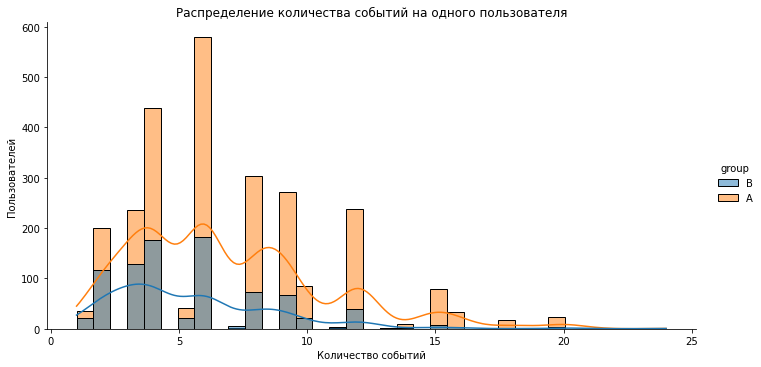

In [12]:
count = data.groupby(['user_id','group'])['event_dt'].count().reset_index()
plt.figure(figsize=(8,10))
sns.displot(x='event_dt',
            kde=True,
            hue='group',
            aspect=2,
            data=count);
plt.title('Распределение количества событий на одного пользователя')
plt.xlabel('Количество событий')
plt.ylabel('Пользователей')
plt.show()

Пользователи группы В совершили в среднем в разы меньше действий, чем участники группы А.

### Распределение событий по дням в двух группах пользователей

<Figure size 576x1008 with 0 Axes>

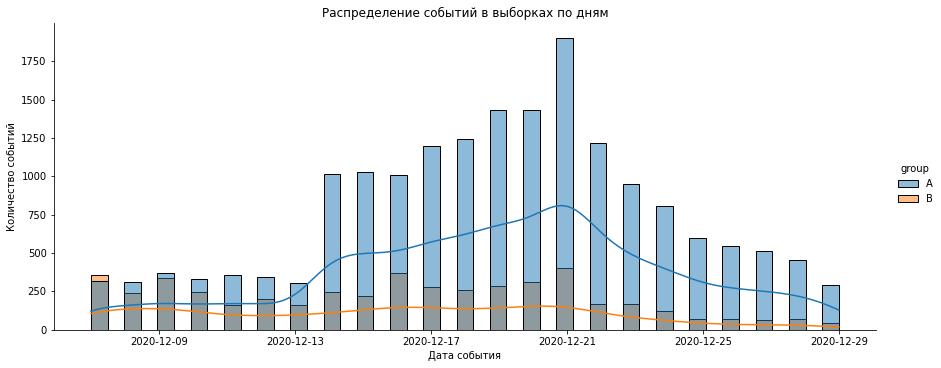

In [13]:
plt.figure(figsize=(8,14))
sns.displot(x='event_date',
            kde=True,
            hue='group',
            aspect=2.5,
            data=data);
plt.title('Распределение событий в выборках по дням')
plt.xlabel('Дата события')
plt.ylabel('Количество событий')
plt.show()

Видим значительное повышение пользовательской активности в период до 20 декабря - скорее всего это связано с покупками к Рождеству с пиком в последний уик-энд перед праздником. Далее идёт стабильное снижение активности пользователей день за днйм до самого конца наблюдений. Несмотря на то, что в группе В гораздо меньше пользователей, в первые дни генерируют почти сколько же событий, сколько и участники группы А.

### Изучение воронки конверсии обоих групп пользователей

In [25]:
fun_a = data.query('group=="A"').groupby(['event_name'], as_index=False)['user_id'].nunique().sort_values('user_id', ascending=False)
fun_b = data.query('group=="B" and user_id not in @deniable_users').groupby(['event_name'], as_index=False)['user_id'].nunique().sort_values('user_id', ascending=False)
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А',
    y = fun_a['event_name'],
    x = fun_a['user_id'],
    textinfo = "label+value+percent initial"))

fig.add_trace(go.Funnel( 
    name = 'Группа B',
    orientation = "h",
    y = fun_b['event_name'],
    x = fun_b['user_id'],
    textposition = "inside",
    textinfo = "label+value+percent initial"))

fig.update_layout(title={'text' : 'Воронка событий для обоих групп',
            'x':0.5,
            'xanchor': 'center'
        },
    autosize=False,
    width=970,
    height=450)
fig.update_yaxes(showticklabels=False)
fig.show()

Здесь мы видим, что количество пользователей на этапе корзины даже меньше, чем на этапе покупки. То есть купить товар можно минуя корзину.

Теперь проверим наших "сомнительных" участников, участвовавших в тесте interface_eu_test во время теста recommender_system_test. Посмотрим, есть ли значительная разница в конверсии у них.

In [26]:
fun_b2 = data.query('group=="B" and user_id in @deniable_users').groupby(['event_name'], as_index=False)['user_id'].nunique().sort_values('user_id', ascending=False)
fig = go.Figure()

fig.add_trace(go.Funnel( 
    name = 'Группа B2',
    orientation = "h",
    y = fun_b2['event_name'],
    x = fun_b2['user_id'],
    textposition = "inside",
    marker = {'color':'red'},
    textinfo = "label+value+percent initial"))

fig.update_layout(title={'text' : 'Воронка событий для пользователей группы B, участвовавших в двух тестах одновременно',
            'x':0.5,
            'xanchor': 'center'
        },
    autosize=False,
    width=970,
    height=450)
fig.update_yaxes(showticklabels=False)
fig.show()

Показатели конверсии здесь немного отличается от показателей "чистых пользователей". Уберём этих пользователей перед проведением статистических тестов.

<a id='section_4'></a>
## Статистические тесты

In [16]:
# общее количество пользователей в группах для нашей будущей функции test_z
groups = raw_users.query('ab_test=="recommender_system_test" and region=="EU"').groupby('group')['user_id'].nunique()
groups

group
A    3634
B    2717
Name: user_id, dtype: int64

In [17]:
cdata = data[~((data['group']=='B')&(data['user_id'].isin(deniable_users)))] #убираем пользователей группы В, участвовавших в параллельном тестировании

In [18]:
#сводная таблица по количеству участников на каждом этапе теста
events_users = cdata.pivot_table(index='event_name', columns='group', values='user_id', aggfunc='nunique').sort_values(by='A', ascending=False).reindex(["login", "product_page", "product_cart", "purchase"]).reset_index()
events_users

group,event_name,A,B
0,login,2604,654
1,product_page,1685,367
2,product_cart,782,184
3,purchase,833,191


Прежде для оптимизации процесса создадим функцию для проверки гипотезы о равенстве долей, где на выходе будет ответ, является ли различие в долях пользователей двух групп, совершивших каждое событие, статистически значимым, либо наоборот, доли равны.

In [19]:
def test_z(g1, g2, alpha):
    for i in events_users.index:

        # доля случаев в первой группе:
        p1 = events_users.loc[i, g1]/groups[g1]

        # доля во второй группе:
        p2 = events_users.loc[i, g2]/groups[g2]

        # пропорция долей в комбинированном датасете:
        p_combined = (events_users.loc[i, g1] + events_users.loc[i, g2]) / (groups[g1] + groups[g2])

        difference = p1 - p2 
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/groups[g1] + 1/groups[g2]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2 


        print(events_users.loc[i,'event_name'], 
              f'\nДоля в группе {g1} - {"{:.2f}%".format(p1*100)}\nДоля в группе {g2} - {"{:.2f}%".format(p2*100)}\np-значение:', "{:.3f}".format(p_value))

        if p_value < alpha: 
            print('Между долями есть значимая разница\n')
        else:
            print('Нет оснований считать доли разными\n')

Применим функцию для нашей сводной таблицы. Для устранения эффекта множественных сравнений мы применим поправку Бонферонни, а именно разделим наш уровень значимости на 4, что равно количеству наших тестов.

In [20]:
test_z('A', 'B', 0.05/4)

login 
Доля в группе A - 71.66%
Доля в группе B - 24.07%
p-значение: 0.000
Между долями есть значимая разница

product_page 
Доля в группе A - 46.37%
Доля в группе B - 13.51%
p-значение: 0.000
Между долями есть значимая разница

product_cart 
Доля в группе A - 21.52%
Доля в группе B - 6.77%
p-значение: 0.000
Между долями есть значимая разница

purchase 
Доля в группе A - 22.92%
Доля в группе B - 7.03%
p-значение: 0.000
Между долями есть значимая разница



Имеется значительная разница в конверсии, если считать от общего количества человек в группах. Особенно это видно на группе В, в которой какие либо события совершали меньше половины участников. Так как в ТЗ наша задача увидеть отличие метрик конверсии именно на трёх последних этапах, сделаем ещё один тест с расчётом конверсии относительно события login, то есть только тех пользователей, что совершали события.

In [21]:
def test_z_2(g1, g2, alpha):
    for i in events_users.index:

        # доля случаев в первой группе:
        p1 = events_users.loc[i, g1]/events_users.loc[0, g1]

        # доля во второй группе:
        p2 = events_users.loc[i, g2]/events_users.loc[0, g2]

        # пропорция долей в комбинированном датасете:
        p_combined = (events_users.loc[i, g1] + events_users.loc[i, g2]) / (events_users.loc[0, g1] + events_users.loc[0, g2])

        difference = p1 - p2 
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/events_users.loc[0, g1] + 1/events_users.loc[0, g2]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1)

        p_value = (1 - distr.cdf(abs(z_value))) * 2 


        print(events_users.loc[i,'event_name'], 
              f'\nДоля в группе {g1} - {"{:.2f}%".format(p1*100)}\nДоля в группе {g2} - {"{:.2f}%".format(p2*100)}\np-значение:', "{:.3f}".format(p_value))

        if p_value < alpha: 
            print('Между долями есть значимая разница\n')
        else:
            print('Нет оснований считать доли разными\n')

In [22]:
test_z_2('A', 'B', 0.05/4)

login 
Доля в группе A - 100.00%
Доля в группе B - 100.00%
p-значение: nan
Нет оснований считать доли разными

product_page 
Доля в группе A - 64.71%
Доля в группе B - 56.12%
p-значение: 0.000
Между долями есть значимая разница

product_cart 
Доля в группе A - 30.03%
Доля в группе B - 28.13%
p-значение: 0.343
Нет оснований считать доли разными

purchase 
Доля в группе A - 31.99%
Доля в группе B - 29.20%
p-значение: 0.170
Нет оснований считать доли разными



Если брать только пользователей, которые совершали события, и считать конверсию от события login, то здесь метрики уже не так сильно отличаются. Но всё же, показатели в группе B несколько хуже, чем в группе А. До улучшения показателей конверсии на 10%, как описано в ожидаемых эффектах, здесь очень далеко.

<a id='section_5'></a>
## Выводы

Главные выводы и факты по результатам проведения исследовательского анализа данных:  
1) Размеры групп сильно отличались, в группе В почти на тысячу пользователей меньше.  
2) Есть пересечение участников с конкурирующим тестом interface_eu_test. Неизвестен дизайн теста и его точные временные рамки. Была отдельно проверена конверсия пользователей, участвовавших в двух тестах, сильных отличий в метриках не замечено.  
3) Указанный период теста - до 4 января, события в датафрейме заканчиваются 30 декабря, не хватает пяти дней наблюдений  
4) Последние шесть дней активности пользователей приходится на маркетинговое событие - *Christmas & New Year Promo*. Примечательно, что в эти дни сама активность людей в генерации событий снижается, так так основные действия совершались до последнего уик-энда перед Рождеством  
5) Из 6351 зарегистрированных участников теста только 3481 совершали какие-то события, в группе B их доля меньше 40 процентов. Этот фактор сильно влияет на мощность и точность исследования.  
6) Пользователи группы А в среднем генерировали более чем в два раза больше событий, чем пользователи группы В.  
7) Событие "покупка" совершалось чаще, чем событие "продуктовая корзина", что выходит немного за рамки ожидаемой воронки продаж. Получается, что для покупки товара необязательно переходить на экран корзины. 

По результатам проведения статистических тестов долей пользователей на каждом этапе воронки продаж можно прийти к выводу, что показатели конверсии группы В незначительно уступают группе А. Ожидаемый эффект в повышении конверсии на 10 процентов не был достигнут ни на одном из трёх этапов(product_page, product_cart, purchase).

Можно сделать вывод, что мы можем остановить данный тест, и зафиксировать отсутствие различий метрик между группами. Наличие некоторых компрометирующих тест факторов, указанных выше, не позволяет в полной мере принять эти результаты как истинные, рекомендую провести тест заново в более чистых условиях.